### import requirements

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from librosa.display import waveplot
import IPython.display as ipd
import pyworld as pw

### load a wave file

In [2]:
y, sr = librosa.load('./I_have_nothing.wav')
print(f'Sampling frequency is {sr}\nNumber of samples is {len(y)}\nclip length in sec is {len(y)/sr}')

Sampling frequency is 22050
Number of samples is 375296
clip length in sec is 17.020226757369613


### view the waveform and play it

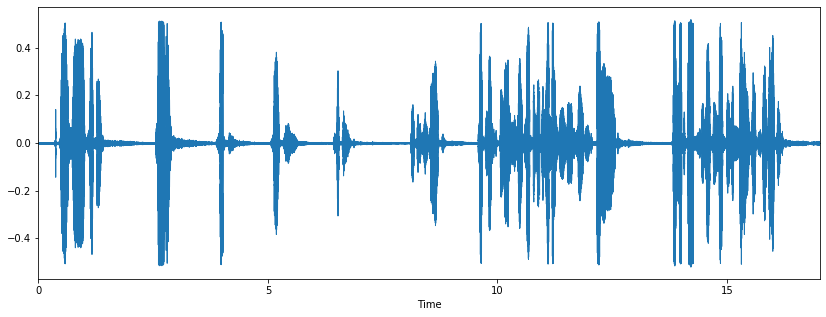

In [3]:
plt.figure(figsize=(14, 5))
figure = waveplot(y, sr=sr)
plt.show()
ipd.Audio(y, rate=sr) 

### what exactly does the sr mean? can you explain this?

In [4]:
ipd.Audio(y, rate=sr*1.5) 

In [5]:
ipd.Audio(y, rate=sr*0.5)

### view a smaller section

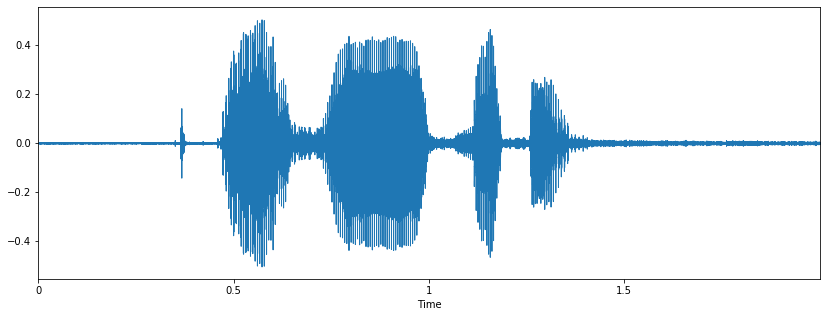

In [6]:
small_y = y[0*sr:2*sr]
plt.figure(figsize=(14, 5))
figure = waveplot(small_y)
plt.show()
ipd.Audio(small_y, rate=sr) 

### Le spectrogram 

![stft](img/stft.png)

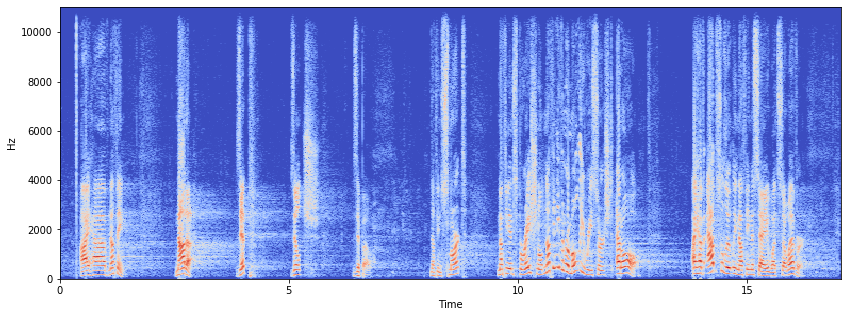

In [7]:
X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.show()

## what each slice represents and what can we learn from it?

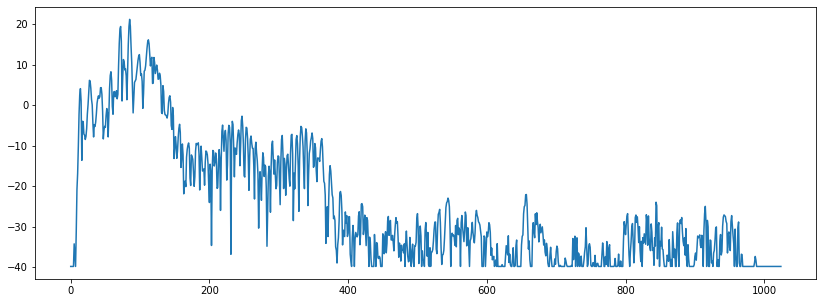

In [8]:
plt.figure(figsize=(14, 5))
plt.plot(Xdb[:,20])
plt.show()

## What is F0 contoure

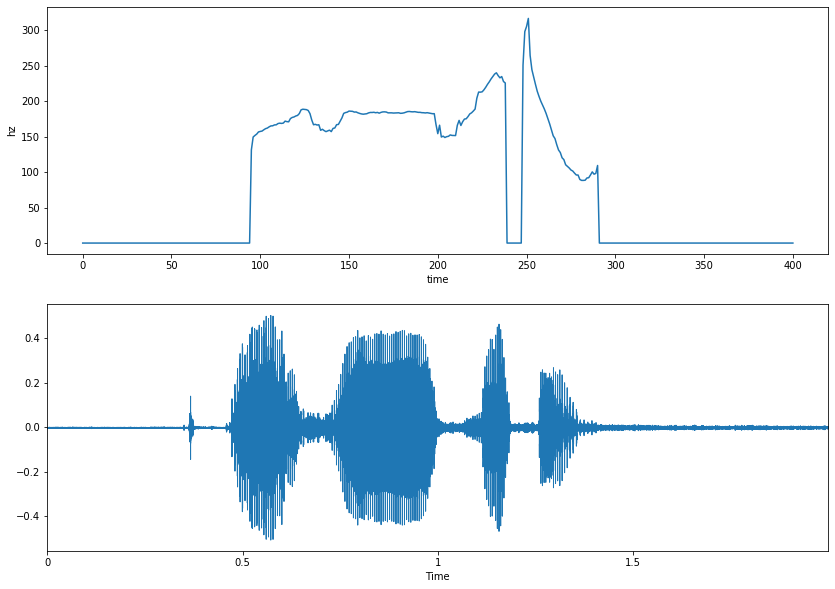

In [9]:
signal = small_y
_f0, t = pw.dio(signal.astype(np.double), sr)    # raw pitch extractor
f0 = pw.stonemask(signal.astype(np.double), _f0, t, sr)  # pitch refinement
plt.figure(figsize=(14, 10))
plt.subplot(2,1,1)
plt.plot(f0 )
plt.xlabel('time')
plt.ylabel('hz')
plt.subplot(2,1,2)
figure = waveplot(signal, sr=sr)
ipd.Audio(signal, rate=sr) 

## What is WORLD

In [10]:
signal = small_y
# feature extraction
_f0, t = pw.dio(signal.astype(np.double), sr)    # raw pitch extractor
f0 = pw.stonemask(signal.astype(np.double), _f0, t, sr)  # pitch refinement
# what happens if we uncomment this 
# f0 = 3*f0
# what happens if we uncomment this 
# f0 = 0.6*f0
sp = pw.cheaptrick(signal.astype(np.double), f0, t, sr)  # extract smoothed spectrogram
ap = pw.d4c(signal.astype(np.double), f0, t, sr)         # extract aperiodicity

# resynthesis
synth_signal = pw.synthesize(f0, sp, ap, sr)
ipd.Audio(signal, rate=sr) 

In [11]:
ipd.Audio(synth_signal, rate=sr) 

### computing the MFCC

In [14]:
def showMfcc(mfcc,delta_mfcc,delta2_mfcc):
    plt.figure(figsize=(12, 6))

    plt.subplot(3,1,1)
    librosa.display.specshow(mfcc)
    plt.ylabel('MFCC')
    plt.colorbar()

    plt.subplot(3,1,2)
    librosa.display.specshow(delta_mfcc)
    plt.ylabel('MFCC-$\Delta$')
    plt.colorbar()

    plt.subplot(3,1,3)
    librosa.display.specshow(delta2_mfcc, sr=sr)
    plt.ylabel('MFCC-$\Delta^2$')
    plt.colorbar()
    plt.tight_layout()

mfcc shape (13, 87)


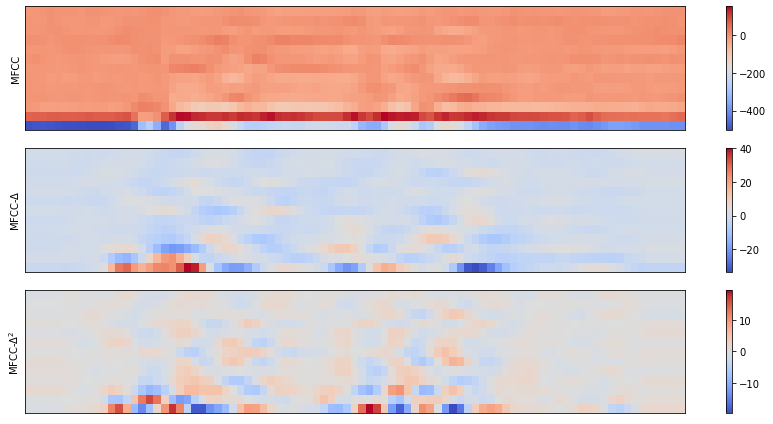

In [16]:
# Next, we'll extract the first 13 Mel-frequency cepstral coefficients (MFCCs)
hop_length = 512 #(why?)
mfcc = librosa.feature.mfcc(y=small_y, sr=sr, hop_length=hop_length, n_mfcc=13)
print(f'mfcc shape {mfcc.shape}') # why?
# what happens if we uncomment this 
# mfcc = mfcc[1:][:] 

# Padding first and second deltas
delta_mfcc  = librosa.feature.delta(mfcc)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

# We'll show each in its own subplot
showMfcc(mfcc, delta_mfcc, delta2_mfcc)

### Quiz:
How can I train an LM model using these representations

### option 1 GMM


[here](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)

**what is GMM**
![GMM](img/GMM.png)

prefered parameters:
* covariance_type: diag
* init_params: kmeans
* n_components: 512-2048

**How can I use it for classification**
* train a GMM for every class   `model1.fit(delta_mfcc_train)`
* during the training process every window represents a training example 
* during inference we use the average log_liklihood `model1.score(utterance1)` (Why?)
* the sample belongs to the GMM with the highest score 


**There are other options based on GMM like GMM-UBM and I-vectors**

## Your Homework